# exercises 01

## Exploratory Weather Data Analysis 

Exploratory analysis of weather data

In [1]:
### Import dependencies 
import pandas as pd # Adding dataframe functionality
from matplotlib import pyplot as plt # Add plotting functionality
from statistics import mean
import folium, json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from statsmodels import stats as stats 
import math

In [2]:
### Read in the weather data from a .csv-file 
weather_data = pd.read_csv("../Data/Raw/weather/weather.csv", sep=",")

In [3]:
### Print the dimensions of the data as well as all the fields 
print(f"Length of the data: {len(weather_data)}")
print(f"Fields: {len(weather_data.columns)}")
for i in weather_data.columns:
    print(i)

Length of the data: 20220
Fields: 9
date
iso3166-2
RelativeHumiditySurface
SolarRadiation
Surfacepressure
TemperatureAboveGround
Totalprecipitation
UVIndex
WindSpeed


In [4]:
### Check for missing values in the data set 
weather_data.isnull().values.any()

False

In [5]:
### Add two new columns based on the iso3166-2 column to 
### create a "country"-column and a "region"-column
weather_data[["country","region"]]= weather_data["iso3166-2"].str.split("-",expand=True)


In [6]:
### Filter the data based on the country
nl_data = weather_data[weather_data["country"] == "NL"]

In [7]:
### Group data based on region and for each region calculate 
### min, max, mean and median for each numeric column. 
### For each of the regions, write these to a file named after the region
agg_data = nl_data.groupby("region")
for i in agg_data:
    # print(i[0])
    # print(i[1])
    with open(f"{i[0]}_summary.txt","w") as outfile:
        outfile.write(str(i[1].describe()))

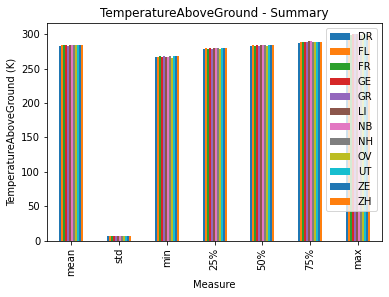

In [8]:
### Plot TemperatureAboveGround 
tmp_df = pd.DataFrame()
for i in agg_data:
    
    tmp = i[1].describe()
    tmp_df[i[0]] = tmp["TemperatureAboveGround"][1:]
tmp_df.plot(kind="bar")
plt.title("TemperatureAboveGround - Summary")
plt.ylabel("TemperatureAboveGround (K)")
plt.xlabel("Measure")
plt.show()

In [9]:
### Group data based on date and calculate means of all 
### numerical columns 
agg_data = nl_data.groupby("date")
mean_data = {}
index = []
for i in agg_data:
    index.append(i[0])
    tmp = i[1].describe()
    for j in tmp:
        if j in mean_data.keys():
            mean_data[j].append(tmp[j]["mean"])
        else:
            mean_data[j] = [tmp[j]["mean"]]
new_data = pd.DataFrame(mean_data,index=index)
new_data.index = pd.to_datetime(new_data.index)

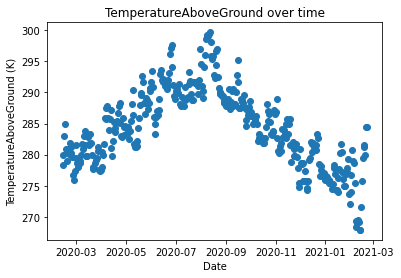

In [10]:
### Plot TemperatureAboveGround v. time 
plt.plot_date(new_data.index, new_data["TemperatureAboveGround"],xdate=True)
plt.title("TemperatureAboveGround over time")
plt.ylabel("TemperatureAboveGround (K)")
plt.xlabel("Date")
plt.show()
# print(new_data)

# exercises 02

### GETTING USED TO PLOT GEOJSON

In [11]:
nl_coronadata = "../Data/Raw/corona/nl_corona.csv"
nl_metadata = "../Data/Raw/metadata/nl_metadata.json"
nl_geojson = "../Data/Raw/shapefiles/nl.geojson"

corona_df = pd.read_csv(nl_coronadata, sep = "\t")

with open(nl_metadata, "r") as f:
    country_metadata = json.load(f)

with open(nl_geojson, "r") as f:
    geojson = json.load(f)

In [12]:
m = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")
m

### GEODATA WRANGLING

In [13]:
covid_region_map = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

corona_df["iso3166-2"] = corona_df["region_code"].map(covid_region_map)

corona_df_by_region = corona_df.groupby(by = "region_name")["hospitalized_addition"].sum().reset_index()

population_map = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}

corona_df_by_region["population"] = corona_df_by_region["region_name"].map(population_map)

corona_df["region_name"]=corona_df['region_name'].str.replace("Noord-Holland", "North Holland")
corona_df["region_name"]=corona_df['region_name'].str.replace("Noord-Brabant", "North Brabant")
corona_df["region_name"]=corona_df['region_name'].str.replace("Zuid-Holland", "South Holland")

region_map = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
corona_df_by_region["iso3166-2"] = corona_df_by_region["region_name"].map(region_map)

cases_per_population_map = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: corona_df_by_region["hospitalized_addition"][i]/corona_df_by_region["population"][i] for i in range(len(country_metadata["country_metadata"]))}
corona_df_by_region["cases_per_population"] = corona_df_by_region["region_name"].map(cases_per_population_map)

corona_df_by_region

,region_name,hospitalized_addition,population,iso3166-2,cases_per_population
0,Drenthe,363.0,493657.0,NL-DR,0.000735
1,Flevoland,519.0,422979.0,NL-FL,0.001227
2,Friesland,349.0,649944.0,NL-FR,0.000537
3,Gelderland,2510.0,2086142.0,NL-GE,0.001203
4,Groningen,279.0,586061.0,NL-GR,0.000476
5,Limburg,2191.0,1117164.0,NL-LI,0.001961
6,Noord-Brabant,4207.0,NaN,NaN,NaN
7,Noord-Holland,3662.0,NaN,NaN,NaN
8,Overijssel,1125.0,1162500.0,NL-OV,0.000968
9,Utrecht,1964.0,1354979.0,NL-UT,0.001449


### GEODATA VISUALISATION

In [14]:
m_cases = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases",
    data = corona_df_by_region,
    columns = ["iso3166-2", "hospitalized_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "Hospitalized",
).add_to(m_cases)

folium.LayerControl().add_to(m_cases)

m_cases

In [15]:
m_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "population",
    data = corona_df_by_region,
    columns = ["iso3166-2", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_population)

m_population

In [16]:
m_cases_per_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases per population",
    data = corona_df_by_region,
    columns = ["iso3166-2", "cases_per_population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_cases_per_population)

m_cases_per_population

# exercises 03

In [17]:
## cleaning corona data
# how many rows are we losing during the filtering of data?
rows_lost = nl_data.shape[0] - corona_df.shape[0]
rows_lost

156

In [18]:
merged = nl_data.merge(corona_df, on = ["date", "iso3166-2"])

#check if there are any NA values
#merged.isna().any()

merged = merged.dropna()
#losing more rows after dropping NaN values
#nl_data

for var in merged.columns[2:9]:
    print(var)
    merged[var] = merged[var].astype('float')
merged['hospitalized_addition'] = merged['hospitalized_addition'].astype('float')
print(merged.dtypes)
merged.replace([np.inf,-np.inf],np.nan,inplace=True)
merged.dropna(inplace=True)
merged.isna().any()
merged.isin([np.inf,-np.inf]).values.sum()

RelativeHumiditySurface
SolarRadiation
Surfacepressure
TemperatureAboveGround
Totalprecipitation
UVIndex
WindSpeed
date                        object
iso3166-2                   object
RelativeHumiditySurface    float64
SolarRadiation             float64
Surfacepressure            float64
TemperatureAboveGround     float64
Totalprecipitation         float64
UVIndex                    float64
WindSpeed                  float64
country                     object
region                      object
region_name                 object
region_code                  int64
deceased_addition          float64
confirmed_addition         float64
hospitalized_addition      float64
deceased_cumulative        float64
confirmed_cumulative         int64
hospitalized_cumulative    float64
dtype: object


0

In [19]:
"""
v = []
for i in nl_data.columns:
    v.append(i)
print(v)
v2 = v[2:-2]
"""

v2 = merged.columns[2:9] 

corr_pearson = {}
corr_spearman = {}
corr_pearson_log = {}

#calculating the pearson correlation along with p-value
for var in v2:
    corr_pearson[var] = pearsonr(merged["hospitalized_addition"], merged[var])
# print(corr_pearson)
#calculating the spearman correlation along with p-value
for var in v2:
    corr_spearman[var] = spearmanr(merged["hospitalized_addition"], merged[var])
# print(corr_spearman)
#calculating the log-log pearson correlation along with p-value
#doesn't work :(

merged['log_hospital'] = np.log(merged['hospitalized_addition'])
new_merged = merged
new_merged.replace([np.inf,-np.inf],np.nan,inplace=True)
new_merged.dropna(inplace=True)
new_merged.isna().any()
for var in v2:
    new_merged = merged
    new_merged[f"log_{var}"] = np.log(new_merged[var])
    new_merged.replace([np.inf,-np.inf],np.nan,inplace=True)
    new_merged.dropna(inplace=True)
    new_merged.isna().any()
     
    corr_pearson_log[var] = pearsonr(new_merged['log_hospital'], new_merged[f"log_{var}"])

pvals = [corr_pearson[i][0] for i in corr_pearson]
pvals.extend([corr_spearman[i][0] for i in corr_spearman])
pvals.extend([corr_pearson_log[i][0] for i in corr_pearson_log])
print(pvals)
# print(len(pvals))
b_results, b_p_adjusted, _, b_alpha_adjusted = stats.multitest.multipletests(pvals,alpha=0.05,method="bonferroni")
print(b_p_adjusted.tolist())
print(b_results.tolist())
h_results, h_p_adjusted, _, h_alpha_adjusted = stats.multitest.multipletests(pvals,alpha=0.05,method="holm")
print(h_p_adjusted.tolist())
print(h_results.tolist())

/home/kofod/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kofod/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[-0.12630708365813156, 0.008996045710151246, 0.09868832971346295, -0.2126713437204372, -0.06700045201228028, -0.16276411285519668, 0.053448008575361666, 0.1220506141047999, -0.24340132796520916, 0.024542658885898724, -0.49580245863133826, -0.06101268460368233, -0.4547388447638414, 0.0986878786903382, -0.13617136819562847, 0.025762627552566756, 0.08909694198000845, -0.17943306950221136, -0.015042557130927078, -0.16788709827074674, 0.07537367552322172]
[-2.6524487568207626, 0.18891695991317617, 1.0, -4.466098218129181, -1.4070094922578857, -3.4180463699591304, 1.0, 1.0, -5.111427887269392, 0.5153958366038732, -10.411851631258104, -1.281266376677329, -9.54951574004067, 1.0, -2.859598732108198, 0.5410151786039019, 1.0, -3.7680944595464383, -0.3158936997494686, -3.5256290636856815, 1.0]
[True, False, False, True, True, True, False, False, True, False, True, True, True, False, True, False, False, True, True, True, False]
[-1.6419920875557104, 0.08096441139136122, 0.3768683776161086, -3.82808

In [35]:
corr_pearson_df = pd.DataFrame(corr_pearson).transpose()
corr_pearson_df[["Correlation", "p-values"]] = corr_pearson_df[[1,0]]
corr_pearson_df.drop([0,1],axis=1,inplace=True)
with open("../Reports/tables/pearson.tex","w") as outfile:
    outfile.write(corr_pearson_df.to_latex())


corr_spearman_df = pd.DataFrame(corr_spearman).transpose()
corr_spearman_df[["Correlation", "p-values"]] = corr_spearman_df[[1,0]]
corr_spearman_df.drop([0,1],axis=1,inplace=True)
with open("../Reports/tables/spearman.tex","w") as outfile:
    outfile.write(corr_spearman_df.to_latex())

# corr_pearson_log_df = pd.DataFrame(corr_pearson_log).transpose()
# print(corr_pearson_log_df)
# corr_pearson_log_df[["Correlation", "p-values"]] = corr_pearson_log_df[[1,0]]
# corr_pearson_log_df.drop([0,1],axis=1,inplace=True)
# with open("../Reports/tables/pearson_log.tex","w") as outfile:
#     outfile.write(corr_pearson_log_df.to_latex())

,0,1
RelativeHumiditySurface,-0.126307,3.429129e-16
SolarRadiation,0.008996,5.628132e-01
Surfacepressure,0.098688,1.971974e-10
TemperatureAboveGround,-0.212671,1.496281e-43
Totalprecipitation,-0.067000,1.599316e-05
UVIndex,-0.162764,5.656131e-26
WindSpeed,0.053448,5.808188e-04


# exercises 04

In [20]:
country_metadata

{'country_data_sources': {'iso3166-1': 'https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2',
  'iso3166-2': 'https://en.wikipedia.org/wiki/ISO_3166-2',
  'population': 'https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70072NED/table?fromstatweb',
  'geo_data': 'https://www.naturalearthdata.com/downloads/10m-cultural-vectors/',
  'geo_data_comments': "Filtered to 'Province', hereby excluding NL regions in the Caraïben.",
  'covid_data_provider': 'Open Source Data Initiative: https://github.com/J535D165/CoronaWatchNL',
  'covid_data_path': 'https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-json/data-provincial/RIVM_NL_provincial_latest.json'},
 'country_metadata': [{'iso3166-1_code': 'NL',
   'iso3166-1_name': 'The Netherlands',
   'iso3166-2_code': 'NL-DR',
   'iso3166-2_name_en': 'Drenthe',
   'population': 493657,
   'covid_region_code': '22'},
  {'iso3166-1_code': 'NL',
   'iso3166-1_name': 'The Netherlands',
   'iso3166-2_code': 'NL-FL',
   'iso3166-2_name_en': 'Fl

In [21]:
rm = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
corona_df["region"] = corona_df["region_code"].map(rm)

pm = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}
corona_df["population"] = corona_df["region_name"].map(pm)

corona_df["cases_pc"] = corona_df["hospitalized_addition"] / corona_df["population"]

df = corona_df.merge(nl_data, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
df = df.drop(["region_code", "region_y"], axis = 1)

df = df.dropna()
df.replace([np.inf,-np.inf],np.nan,inplace=True)
df.dropna(inplace=True)
df.isna().any()
df.isin([np.inf,-np.inf]).values.sum()
df

,date,region_name,deceased_addition,confirmed_addition,hospitalized_addition,deceased_cumulative,confirmed_cumulative,hospitalized_cumulative,iso3166-2_x,region_x,...,cases_pc,iso3166-2_y,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,country
192,2020-03-14,Drenthe,0.0,2.0,0.0,0.0,15,0.0,NL-DR,NL-DR,...,0.000000,NL-DR,76.175131,5.677015e+06,2.444319e+06,278.645045,0.000246,10.722513,3.870691,NL
193,2020-03-14,Flevoland,0.0,7.0,0.0,0.0,14,3.0,NL-FL,NL-FL,...,0.000000,NL-FL,80.302209,7.426985e+06,2.443688e+06,279.671005,0.000252,9.391304,5.326425,NL
194,2020-03-14,Friesland,0.0,1.0,0.0,0.0,8,1.0,NL-FR,NL-FR,...,0.000000,NL-FR,77.900978,6.994390e+06,2.444151e+06,279.227731,0.000179,10.532446,5.612008,NL
195,2020-03-14,Gelderland,1.0,12.0,5.0,1.0,76,14.0,NL-GE,NL-GE,...,0.000002,NL-GE,77.892281,7.956310e+06,2.441177e+06,279.821025,0.000212,10.868673,3.875319,NL
196,2020-03-14,Groningen,0.0,0.0,0.0,0.0,4,1.0,NL-GR,NL-GR,...,0.000000,NL-GR,74.633632,5.360761e+06,2.446000e+06,278.622180,0.000100,10.408840,4.368198,NL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,2021-02-21,North Holland,2.0,959.0,11.0,2200.0,179755,3654.0,NL-NH,NL-NH,...,0.000004,NL-NH,75.253727,5.696371e+06,2.429628e+06,283.445914,0.000000,5.766284,4.694117,NL
4328,2021-02-21,Overijssel,0.0,172.0,2.0,1017.0,74162,1123.0,NL-OV,NL-OV,...,0.000002,NL-OV,69.729526,6.547145e+06,2.428964e+06,284.413133,0.000000,5.921844,3.537233,NL
4329,2021-02-21,Utrecht,3.0,324.0,5.0,1110.0,84158,1967.0,NL-UT,NL-UT,...,0.000004,NL-UT,70.287774,6.386869e+06,2.429348e+06,284.654022,0.000000,5.903930,3.833734,NL
4330,2021-02-21,Zeeland,0.0,79.0,0.0,170.0,15910,455.0,NL-ZE,NL-ZE,...,0.000000,NL-ZE,67.850837,6.807321e+06,2.428021e+06,284.711623,0.000000,5.975684,4.871302,NL


In [22]:
df = sm.add_constant(df)

v = []
for i in nl_data.columns:
    v.append(i)
v = v[2:-2]

v.append("const")
v

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['RelativeHumiditySurface',
 'SolarRadiation',
 'Surfacepressure',
 'TemperatureAboveGround',
 'Totalprecipitation',
 'UVIndex',
 'WindSpeed',
 'const']

In [23]:
est = sm.OLS(df["hospitalized_addition"], df[v], hasconst = True).fit()
print(est.summary())

                              OLS Regression Results                             
Dep. Variable:     hospitalized_addition   R-squared:                       0.137
Model:                               OLS   Adj. R-squared:                  0.136
Method:                    Least Squares   F-statistic:                     93.97
Date:                   Fri, 04 Mar 2022   Prob (F-statistic):          1.17e-127
Time:                           11:11:53   Log-Likelihood:                -16184.
No. Observations:                   4140   AIC:                         3.238e+04
Df Residuals:                       4132   BIC:                         3.243e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [24]:
est = sm.OLS(np.where(df["hospitalized_addition"] > 1.0e-10, np.log(df["hospitalized_addition"]), -10), df[v], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     300.7
Date:                Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:11:53   Log-Likelihood:                -12177.
No. Observations:                4140   AIC:                         2.437e+04
Df Residuals:                    4132   BIC:                         2.442e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

/home/kofod/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kofod/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     115.4
Date:                Fri, 04 Mar 2022   Prob (F-statistic):          3.90e-155
Time:                        11:11:53   Log-Likelihood:                 43471.
No. Observations:                4140   AIC:                        -8.693e+04
Df Residuals:                    4132   BIC:                        -8.688e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface -1

In [26]:
regions = ["const",]

for region in set(df["iso3166-2_x"]):
    if region != "DK-81":
        df[region] = (df["iso3166-2_x"] == region).astype(int)
        regions.append(region)
        v.append(region)


In [27]:
est = sm.OLS(np.log(df["cases_pc"] + 1), df[regions], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     11.51
Date:                Fri, 04 Mar 2022   Prob (F-statistic):           1.91e-21
Time:                        11:11:54   Log-Likelihood:                 43164.
No. Observations:                4140   AIC:                        -8.630e+04
Df Residuals:                    4128   BIC:                        -8.623e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.058e+06   1.78e+07     -0.059      0.9

In [28]:
est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     54.84
Date:                Fri, 04 Mar 2022   Prob (F-statistic):          1.09e-176
Time:                        11:11:54   Log-Likelihood:                 43546.
No. Observations:                4140   AIC:                        -8.705e+04
Df Residuals:                    4121   BIC:                        -8.693e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface -1

In [29]:
est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": df["iso3166-2_x"]}, use_t = True)
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     1991.
Date:                Fri, 04 Mar 2022   Prob (F-statistic):           3.61e-16
Time:                        11:11:54   Log-Likelihood:                 43546.
No. Observations:                4140   AIC:                        -8.705e+04
Df Residuals:                    4121   BIC:                        -8.693e+04
Df Model:                          18                                         
Covariance Type:              cluster                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface -1

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 7
  warnings.warn('covariance of constraints does not have full '
